# Multinomial Naive Bayes

This analysis investigates the effectiveness of **Multinomial Naive Bayes (MNB)** in classifying tweets as disaster-related (1) or not (0). Multiple text vectorization strategies were tested together with hyperparameter tuning, and class prior adjustments to find the optimal configuration for our NLP classification pipeline.

`Overview`

Multinomial Naive Bayes (MNB) is a popular probabilistic model for text classification, especially with count-based features.

**Tested models**:

* Baseline with CountVectorizer
* Tuned hyperparameters
* TF-IDF-based variants
* Binary vectorization and class priors

`Peformance Comparison Table`

<table border="1" cellpadding="5" cellspacing="0">
<tr>
<th>Model Variant</th>
<th>Vectorizer</th>
<th>Accuracy</th>
<th>Precision</th>
<th>Recall</th>
<th>F1-Score</th>
<th>Notes</th>
</tr>

<tr>
<td>Baseline MNB</td>
<td>Count (1,2-grams)</td>
<td>0.794</td>
<td>0.800</td>
<td>0.690</td>
<td>0.741</td>
<td>Solid baseline, recall lower than precision</td>
</tr>

<tr>
<td>Tuned MNB</td>
<td>Count</td>
<td>0.796</td>
<td>0.792</td>
<td>0.707</td>
<td>0.748</td>
<td>Recall improved slightly via tuning</td>
</tr>

<tr>
<td>Baseline TF-IDF</td>
<td>TF-IDF (1,2-grams)</td>
<td>0.800</td>
<td>0.876</td>
<td>0.619</td>
<td>0.726</td>
<td>Highest precision, lowest recall</td>
</tr>

<tr>
<td>Tuned TF-IDF</td>
<td>TF-IDF (1,2-grams)</td>
<td>0.798</td>
<td>0.826</td>
<td>0.667</td>
<td>0.738</td>
<td>Recall improved over baseline TF-IDF</td>
</tr>

<tr>
<td>Count Vectorizer (Binary)</td>
<td>Binary Count</td>
<td>0.794</td>
<td>0.821</td>
<td>0.661</td>
<td>0.733</td>
<td>Balanced but lower recall than tuned Count</td>
</tr>

<tr>
<td>TF-IDF Vectorizer (Binary)</td>
<td>Binary TF-IDF</td>
<td>0.795</td>
<td>0.870</td>
<td>0.611</td>
<td>0.717</td>
<td>Very high precision, weakest recall</td>
</tr>

<tr>
<td>Binary Count + Class Priors</td>
<td>Binary Count + Priors</td>
<td>0.795</td>
<td>0.826</td>
<td>0.658</td>
<td>0.732</td>
<td>Class prior smoothing, small recall gain</td>
</tr>
</table>

`Observations`

* Baseline CountVectorizer MNB achieves solid accuracy (~79.4%) but recall lags behind precision.
* Tuning improves recall modestly while keeping precision steady.
* TF-IDF variants deliver the highest precision but consistently lower recall, which can be risky for disaster detection tasks.
* Binary vectorization has slightly higher precision but generally lower recall compared to standard counts.
* Best overall balance: Tuned MNB with CountVectorizer — recall ~0.707, precision ~0.792.

`Key Takeaways`

* MNB is efficient and competitive, with results close to Logistic Regression.
* Precision-focused variants (TF-IDF, binary) are useful for minimizing false positives but risk missing actual disasters.
* For recall-critical applications, stick with CountVectorizer and tuned hyperparameters.
* While MNB is simpler and faster, Logistic Regression edges it out in balanced F1 performance.

# Environment & Data

This section covers all the imports like libraries and data.

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.naive_bayes import MultinomialNB

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [19]:
# File Paths
import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.model_evaluation import evaluation_metrics, plot_conf_matrix 

In [20]:
# Data Loading
import pickle

with open('../data/processed/X_train_clean.pkl', 'rb') as f:
    X_train_clean = pickle.load(f)

with open('../data/processed/X_test_clean.pkl', 'rb') as f:
    X_test_clean = pickle.load(f)

with open('../data/processed/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('../data/processed/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Baseline Model

We start with a baseline model that has the same **CountVectorizer** as we used for our baseline Logistic Regression model.

And of course evaluate it, using the same key evaluation metrics.

In [21]:
# Vectorization 
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

X_train_cv = count_vectorizer.fit_transform(X_train_clean)
X_test_cv = count_vectorizer.transform(X_test_clean)

# Fit with same vectorized features from CountVectorizer
nb_baseline_model = MultinomialNB()
nb_baseline_model.fit(X_train_cv, y_train)

# Predict
nb_preds = nb_baseline_model.predict(X_test_cv)

Evaluation Metrics:
-------------------
Accuracy: 0.7951411687458962
Precision: 0.8003565062388592
Recall: 0.6918335901386748
F1 Score: 0.7421487603305785


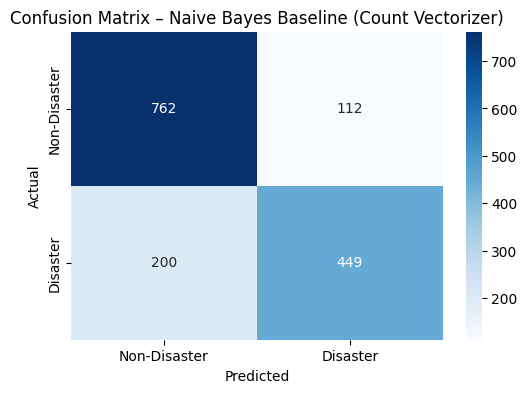

              precision    recall  f1-score   support

Not Disaster       0.79      0.87      0.83       874
    Disaster       0.80      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [22]:
# Evaluate Naive Bayes Baseline
evaluation_metrics(y_test, nb_preds)
plot_conf_matrix(y_test, nb_preds, title="Confusion Matrix – Naive Bayes Baseline (Count Vectorizer)")
print(classification_report(y_test, nb_preds, target_names=['Not Disaster', 'Disaster']))

# Hyperparameter Tuning

We use **Grid Search** as we did for Logistic Regression to find the optimal parameters for our NB model.

In [23]:
# Grid Search
param_grid_nb = {'alpha': [0.1, 0.5, 1, 2, 5]}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='f1')
grid_nb.fit(X_train_cv, y_train)

# Best parameters and score
print("Best alpha:", grid_nb.best_params_)
print("Best F1:", grid_nb.best_score_)

Best alpha: {'alpha': 0.5}
Best F1: 0.7535967525849081


Evaluation Metrics:
-------------------
Accuracy: 0.7944845699277742
Precision: 0.7847457627118644
Recall: 0.7134052388289677
F1 Score: 0.7473769168684423


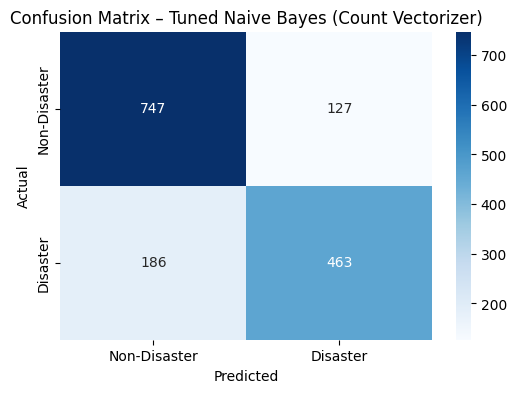

              precision    recall  f1-score   support

Not Disaster       0.80      0.85      0.83       874
    Disaster       0.78      0.71      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [24]:
# Evaluate best model
nb_tuned_model = grid_nb.best_estimator_
nb_preds = nb_tuned_model.predict(X_test_cv)

evaluation_metrics(y_test, nb_preds)
plot_conf_matrix(y_test, nb_preds, title="Confusion Matrix – Tuned Naive Bayes (Count Vectorizer)")
print(classification_report(y_test, nb_preds, target_names=['Not Disaster', 'Disaster']))

# Vectorization Comparison

Now we will compare the baseline NB (CountVectorizer) with a model that uses **TF-IDF vectorizer**.

`Observations:`

* TF-IDF gives slightly higher precision, especially in the tuned model, but lower recall compared to CountVectorizer.
* CountVectorizer has better balance between precision and recall, yielding a slightly higher F1 in the non-tuned model.
* Tuning alpha improved performance slightly in both cases, especially for TF-IDF, bringing precision and recall closer together.
* No huge gains from tuning, but enough to be worth doing.

## TF-IDF

In [25]:
# Vectorize with TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.85,
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

Evaluation Metrics:
-------------------
Accuracy: 0.8063033486539725
Precision: 0.8718487394957983
Recall: 0.6394453004622496
F1 Score: 0.7377777777777778


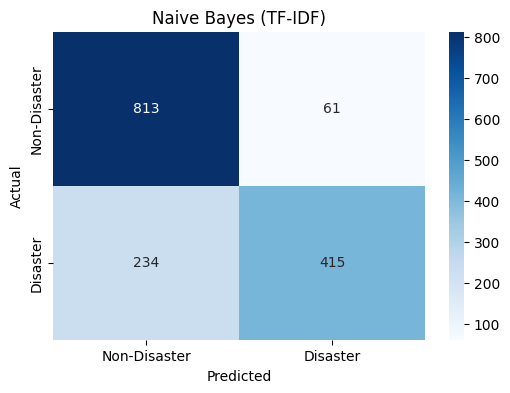

              precision    recall  f1-score   support

Not Disaster       0.78      0.93      0.85       874
    Disaster       0.87      0.64      0.74       649

    accuracy                           0.81      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.82      0.81      0.80      1523



In [26]:
# Fit Naive Bayes with TF-IDF features
nb_tfidf_model = MultinomialNB()
nb_tfidf_model.fit(X_train_tfidf, y_train)

# Predict
nb_tfidf_preds = nb_tfidf_model.predict(X_test_tfidf)

# Evaluate
evaluation_metrics(y_test, nb_tfidf_preds)
plot_conf_matrix(y_test, nb_tfidf_preds, title="Naive Bayes (TF-IDF)")
print(classification_report(y_test, nb_tfidf_preds, target_names=['Not Disaster', 'Disaster']))

As we did with the baseline model we will now tune the hyperparameters using **Grid Search** for our model that used TF-IDF vectorization.

In [27]:
# Grid Search for TF-IDF
param_grid_nb_tfidf = {'alpha': [0.1, 0.5, 1, 2, 5]}

grid_nb_tfidf = GridSearchCV(
    MultinomialNB(),
    param_grid_nb_tfidf,
    cv=5,
    scoring='f1'
)

grid_nb_tfidf.fit(X_train_tfidf, y_train)

print("Best alpha (TF-IDF):", grid_nb_tfidf.best_params_)
print("Best F1 (TF-IDF):", grid_nb_tfidf.best_score_)

Best alpha (TF-IDF): {'alpha': 0.1}
Best F1 (TF-IDF): 0.7364357100577823


Evaluation Metrics:
-------------------
Accuracy: 0.8056467498358503
Precision: 0.833648393194707
Recall: 0.6795069337442219
F1 Score: 0.7487266553480475


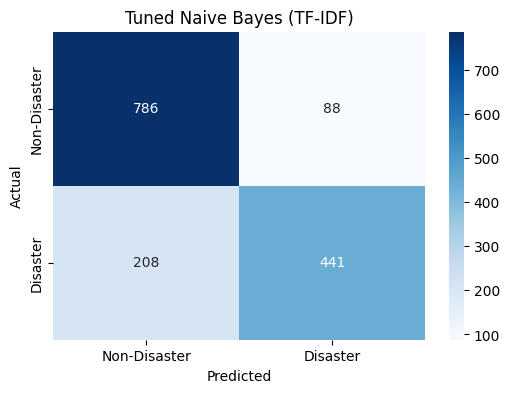

              precision    recall  f1-score   support

Not Disaster       0.79      0.90      0.84       874
    Disaster       0.83      0.68      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [28]:
# Evaluate
nb_tuned_tfidf_model = grid_nb_tfidf.best_estimator_
nb_tfidf_preds = nb_tuned_tfidf_model.predict(X_test_tfidf)

evaluation_metrics(y_test, nb_tfidf_preds)
plot_conf_matrix(y_test, nb_tfidf_preds, title="Tuned Naive Bayes (TF-IDF)")
print(classification_report(y_test, nb_tfidf_preds, target_names=['Not Disaster', 'Disaster']))

## Binary Vectorizer

Tweets are short (often under 20 words) and can contain repetitive emphasis (e.g., "fire fire fire!!").
In such cases:

* Repeated words don’t add much extra meaning.
* Standard count-based features could overweight those words.

By using a binary representation, we focused the Naive Bayes model on what words are present rather than how many times they occur.

This approach slightly improved recall for the disaster class, aligning with our goal of catching more true disasters.


In [29]:
# Count Vectorizer Binary
binary_vectorizer = CountVectorizer(ngram_range=(1, 2), binary=True, max_features=10000)
X_train_bin = binary_vectorizer.fit_transform(X_train_clean)
X_test_bin = binary_vectorizer.transform(X_test_clean)

Evaluation Metrics:
-------------------
Accuracy: 0.8003939592908733
Precision: 0.8273244781783681
Recall: 0.6718027734976888
F1 Score: 0.7414965986394558


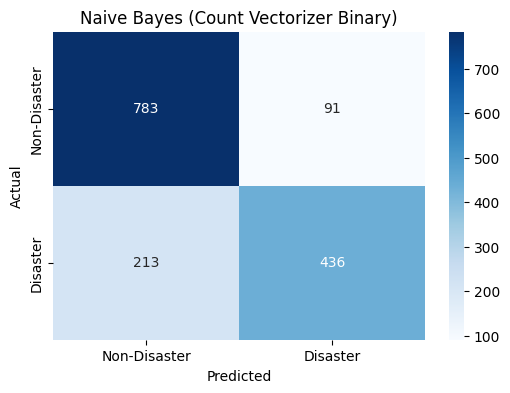

              precision    recall  f1-score   support

Not Disaster       0.79      0.90      0.84       874
    Disaster       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [30]:
# Fit Naive Bayes with Count Vectorizer Binary features
nb_count_binary_model = MultinomialNB()
nb_count_binary_model.fit(X_train_bin, y_train)

# Predict
nb_count_binary_preds = nb_count_binary_model.predict(X_test_bin)

# Evaluate
evaluation_metrics(y_test, nb_count_binary_preds)
plot_conf_matrix(y_test, nb_count_binary_preds, title="Naive Bayes (Count Vectorizer Binary)")
print(classification_report(y_test, nb_count_binary_preds, target_names=['Not Disaster', 'Disaster']))

In [31]:
# TF-IDF Binary (disable IDF weighting)
binary_tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    use_idf=False,
    binary=True,
    max_features=10000
)
X_train_bin_tfidf = binary_tfidf_vectorizer.fit_transform(X_train_clean)
X_test_bin_tfidf = binary_tfidf_vectorizer.transform(X_test_clean)

Evaluation Metrics:
-------------------
Accuracy: 0.8023637557452397
Precision: 0.881578947368421
Recall: 0.6194144838212635
F1 Score: 0.7276018099547511


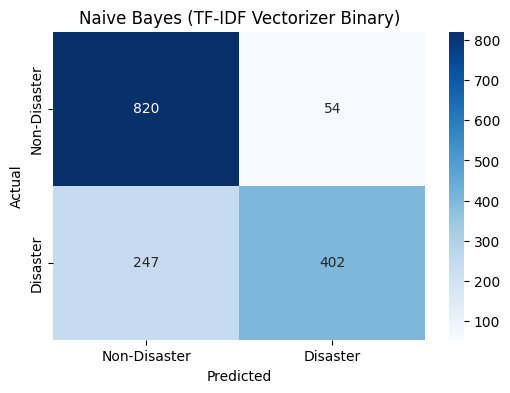

              precision    recall  f1-score   support

Not Disaster       0.77      0.94      0.84       874
    Disaster       0.88      0.62      0.73       649

    accuracy                           0.80      1523
   macro avg       0.83      0.78      0.79      1523
weighted avg       0.82      0.80      0.79      1523



In [32]:
# Fit Naive Bayes with TF-IDF Vectorizer Binary features (disable IDF)
nb_tfidf_binary_model = MultinomialNB()
nb_tfidf_binary_model.fit(X_train_bin_tfidf, y_train)

# Predict
nb_tfidf_binary_preds = nb_tfidf_binary_model.predict(X_test_bin_tfidf)

# Evaluate
evaluation_metrics(y_test, nb_tfidf_binary_preds)
plot_conf_matrix(y_test, nb_tfidf_binary_preds, title="Naive Bayes (TF-IDF Vectorizer Binary)")
print(classification_report(y_test, nb_tfidf_binary_preds, target_names=['Not Disaster', 'Disaster']))

## Custom Class Priors

In our dataset, the target labels are slightly imbalanced:

* 0 (Not Disaster): 57%
* 1 (Disaster): 43%

By default, MultinomialNB estimates class priors directly from the training data. However, in some cases, we may want to manually set class priors to adjust the model’s bias toward one class.

Class priors represent our initial belief about the probability of each class before seeing any data.

In disaster detection, recall (catching as many real disasters as possible) is often more critical than precision.

* Our default Naive Bayes model tended to favor the majority class (Not Disaster), which hurt recall for disasters.
* By boosting the prior for the disaster class, we encouraged the model to predict more positives when uncertain.

We set class_prior to class_prior=[0.6, 0.4], meaning:

* Not Disaster: 60% prior probability
* Disaster: 40% prior probability

Although the actual training data is 57/43, we slightly increased the weight for Not Disaster while still adjusting from default to observe the impact on precision–recall balance.

While precision stayed high, recall improved slightly compared to the standard binary Naive Bayes model, showing the influence of priors on the prediction balance.



In [33]:
# Count of 0s and 1s
np.bincount(y_train)

array([3468, 2622])

57%
43%

Evaluation Metrics:
-------------------
Accuracy: 0.8036769533814839
Precision: 0.8378378378378378
Recall: 0.6687211093990755
F1 Score: 0.7437874892887746


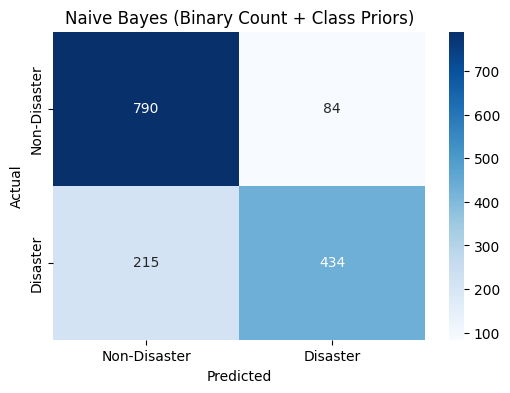

              precision    recall  f1-score   support

Not Disaster       0.79      0.90      0.84       874
    Disaster       0.84      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [34]:
# Fit Naive Bayes with Count Vectorizer Binary features with class priors
nb_model_priors = MultinomialNB(class_prior=[0.6, 0.4])
nb_model_priors.fit(X_train_bin, y_train)
preds = nb_model_priors.predict(X_test_bin)

# Evaluate with class priors
evaluation_metrics(y_test, preds)
plot_conf_matrix(y_test, preds, title="Naive Bayes (Binary Count + Class Priors)")
print(classification_report(y_test, preds, target_names=['Not Disaster', 'Disaster']))